# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

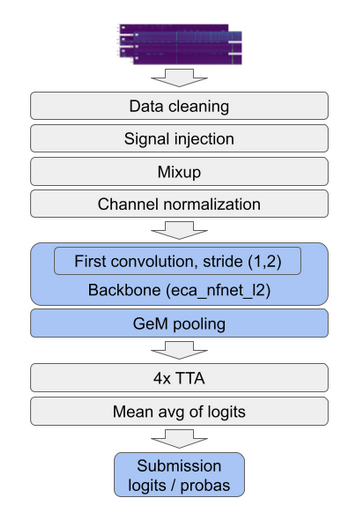

In [1]:
# !pip install timm
# !pip install albumentations
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install torchsummary
# !pip install ray[tune]

In [2]:
import os
import random
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import time
from itertools import chain

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchsummary import summary
from sklearn.decomposition import NMF
from torch.cuda.amp import GradScaler
from torchvision import utils

import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

import numpy as np
import pandas as pd
import timm
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb
from matplotlib import pyplot as plt

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'batch_size': 50,
    'epochs': 5,
    'num_folds': 1
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '500_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

## Shuffle data

In [6]:
initial_data_df = initial_data_df.sample(frac=1).reset_index(drop=True)

In [7]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   string
 1   target          1000 non-null   int32 
 2   image_filepath  1000 non-null   string
dtypes: int32(1), string(2)
memory usage: 19.7 KB


Split the data into 70% train and 30% test:

In [8]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [9]:
def resize_image(image):
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)


def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()


def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)


def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)


def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i]
        off_target_image = sample_images[i+1]

        on_W, on_H = get_decomposition_matrices(on_target_image)
        off_W, off_H = get_decomposition_matrices(off_target_image)
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    return combined_denoised_image

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        images = np.load(images_filepath).astype(np.float32)
        image = get_denoised_image(images)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()

        label = torch.tensor(self.targets[idx]).float()

        return image, label

# Image Augmentation

In [11]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

In [12]:
def mixup(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Weight Random Sampler

In [13]:
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]

    return WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# Train and Validation Dataloaders

In [14]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform = get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform = get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size = config['batch_size'],
        shuffle=True,
        # num_workers=config['num_workers'],
        # sampler = sampler,
        pin_memory = True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size = config['batch_size'],
        shuffle = False,
        # num_workers=config['num_workers'],
        pin_memory = True
    )

    return train_loader, valid_loader

# Model

In [15]:
# https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/#Example_of_PyTorch_Conv2D_in_CNN

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.01)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.01)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.01)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.01)
        )

        self.fc1 = nn.Linear(256, 1, bias=True) # 50x2048 and 107648x625

        nn.init.xavier_uniform(self.fc1.weight)

        # self.layer5 = nn.Sequential(
        #     self.fc1,
        #     # nn.ReLU(),
        #     nn.Dropout(p=0.1)
        # )
        #
        # self.fc2 = torch.nn.Linear(625, 1, bias=True)
        #
        # torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer3(x)
        x = x.view(x.size(0), -1) # flatten for FC
        x = self.fc1(x)
        # x = self.fc2(x)

        return x

# Initialise Model, Loss Function, Optimizer and Scheduler

In [16]:
model = CustomModel()
model = model.to(config['device'])

criterion = nn.BCEWithLogitsLoss().to(config['device'])
# base_optimizer = AdamP
# optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

C:\Users\adnan\AppData\Local\Temp\ipykernel_13744\3436152205.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight)


# Training loop

In [17]:
def get_normalised_predictions(predictions):
    predictions_min = min(predictions)
    predictions_max = max(predictions)

    if predictions_min == predictions_max: # all predictions are the same
        return [0] * len(predictions)

    return [(x - predictions_min) / (predictions_max - predictions_min) for x in predictions]



def get_binary_classification(value):
    return 0 if value < 0.5 else 1



def get_binary_classifications(predictions):
    norm_predictions = np.array(get_normalised_predictions(predictions))
    binary_classification_func = np.vectorize(get_binary_classification)

    return binary_classification_func(norm_predictions)



def get_accuracy(predictions, labels):
    binary_classifications = get_binary_classifications(predictions)
    labels_array = labels.cpu().detach().numpy()
    correct_predictions = (binary_classifications == labels_array)
    correct_predictions_count = np.count_nonzero(correct_predictions)

    return np.mean(correct_predictions_count / len(predictions))



def get_roc_auc_score(output, target):
    try:
        return round(roc_auc_score(target, output), 10)
    except:
        return 0.5



def get_validation_loss_accuracy_rocauc(model, data_loader):
    loss = 0
    accuracy = 0
    roc_auc = 0

    model.eval()

    for x, y in data_loader:
        x, y = x.to(config['device']), y.to(config['device'])

        predictions = model(x)

        loss += criterion(predictions, y.unsqueeze(1)).item()
        accuracy += get_accuracy(predictions.cpu().detach().numpy(), y.unsqueeze(1))
        roc_auc += get_roc_auc_score(predictions, y.unsqueeze(1))


    num_samples = len(data_loader)

    return loss/num_samples, accuracy/num_samples, roc_auc/num_samples

In [18]:
train_data = train_df.iloc[:400,:]
valid_data = train_df.iloc[400:,:]
train_loader, valid_loader = get_loaders(train_df, valid_data, None)

train_losses = []
train_accuracies = []
train_roc_auc_scores = []

valid_losses = []
valid_accuracies = []
valid_roc_auc_scores = []

# sampler = get_sampler(train_data)


for e in range(1, config['epochs']+1):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_train_roc_auc = 0

    epoch_valid_loss = 0
    epoch_valid_acc = 0
    epoch_valid_roc_auc = 0

    start_time = time.time()

    for train_x, train_y in train_loader:
        # train_x is the batched image samples
        # train_y is the batched labels
        train_x, train_y = train_x.to(config['device']), train_y.to(config['device'])

        optimizer.zero_grad()


        # Training
        model.train()

        train_predictions = model(train_x)

        train_loss = criterion(train_predictions, train_y.unsqueeze(1))
        epoch_train_loss += train_loss.item()

        train_acc = get_accuracy(train_predictions.cpu().detach().numpy(), train_y.unsqueeze(1))
        epoch_train_acc += train_acc.item()

        epoch_train_roc_auc += get_roc_auc_score(train_predictions, train_y)


        # Validation
        valid_loss, valid_acc, valid_roc_auc = get_validation_loss_accuracy_rocauc(model, valid_loader)

        epoch_valid_loss += valid_loss
        epoch_valid_acc += valid_acc
        epoch_valid_roc_auc += valid_roc_auc


        # Back propagation
        train_loss.backward()
        optimizer.step()


    end_time = time.time()

    num_samples = len(train_loader)

    train_losses.append(epoch_train_loss / num_samples)
    train_accuracies.append(epoch_train_acc / num_samples)
    train_roc_auc_scores.append(epoch_train_roc_auc / num_samples)

    valid_losses.append(epoch_valid_loss / num_samples)
    valid_accuracies.append(epoch_valid_acc / num_samples)
    valid_roc_auc_scores.append(epoch_valid_roc_auc / num_samples)

    print(f'Epoch {e+0:03}:'
          f' | Train - Loss: {epoch_train_loss / num_samples:.5f}'
          f' | Acc: {epoch_train_acc / num_samples:.3f}'
          f' | ROC AUC: {epoch_valid_roc_auc / num_samples:.3f}'
          f' | Duration (s): {end_time - start_time}')

Epoch 001: | Train - Loss: 3.15056 | Acc: 0.516 | ROC AUC: 0.500 | Duration (s): 197.45852899551392
Epoch 002: | Train - Loss: 0.85794 | Acc: 0.470 | ROC AUC: 0.500 | Duration (s): 182.26141619682312
Epoch 003: | Train - Loss: 0.70212 | Acc: 0.506 | ROC AUC: 0.500 | Duration (s): 188.28244924545288
Epoch 004: | Train - Loss: 0.69819 | Acc: 0.512 | ROC AUC: 0.500 | Duration (s): 197.73719668388367
Epoch 005: | Train - Loss: 0.69875 | Acc: 0.500 | ROC AUC: 0.500 | Duration (s): 205.42015266418457


## Save model

In [19]:
model_name = 'cnn_from_scratch.pth'
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)

os.mkdir(models_dir)

torch.save(model.state_dict(), os.path.join(models_dir, model_name))

print('model saved to: ', os.path.join(models_dir, model_name))

model saved to:  models\22-09-01_19-24-54\cnn_from_scratch.pth


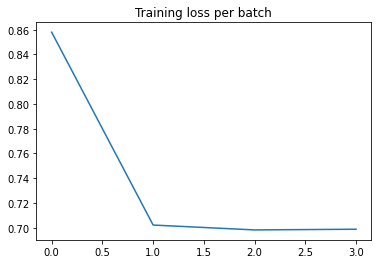

In [20]:
# training loss
plt.title('Training loss per batch')
plt.plot(train_losses[1:])

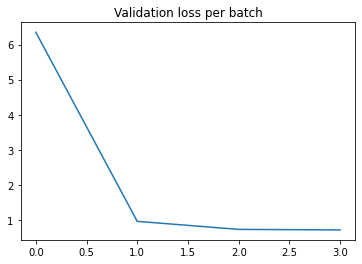

In [21]:
# validation loss
plt.title('Validation loss per batch')
plt.plot(valid_losses[1:])

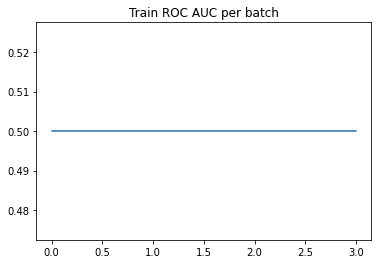

In [22]:
# train roc auc
plt.title('Train ROC AUC per batch')
plt.plot(train_roc_auc_scores[1:])

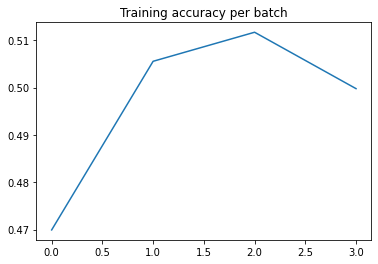

In [23]:
# training accuracy
plt.title('Training accuracy per batch')
plt.plot(train_accuracies[1:])

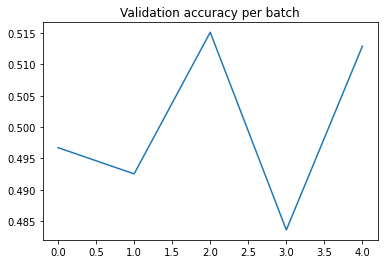

In [24]:
# validation accuracy
plt.title('Validation accuracy per batch')
plt.plot(valid_accuracies)

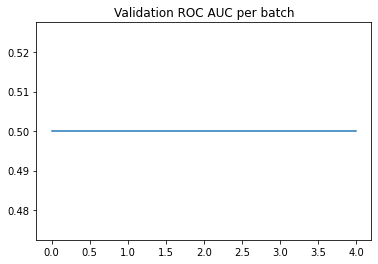

In [25]:
# validation roc auc
plt.title('Validation ROC AUC per batch')
plt.plot(valid_roc_auc_scores)

# Analysis

## Run best performing model against test set

In [26]:
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

In [27]:
test_targets = []
test_outputs = []

model.cuda()
model.eval()

for X_batch, y_batch in get_test_loader(test_df):
    X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])

    y_pred = model(X_batch)

    test_targets.append(y_batch)
    test_outputs.extend([t.item() for t in y_pred])

Prediction values are in a range:

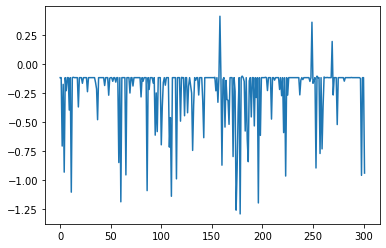

In [28]:
plt.plot(test_outputs)

Normalise between 0, 1 and use 0.5 as threshold for binary classification:

In [29]:
normalised_predictions = get_normalised_predictions(test_outputs)

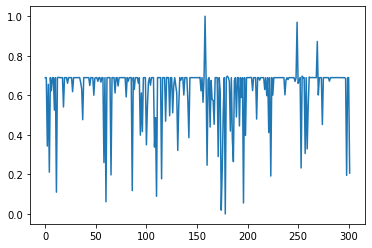

In [30]:
plt.plot(normalised_predictions)

Map to binary classifications using sigmoid function:

In [31]:
test_targets_float = [x.cpu().numpy() for x in test_targets]
test_targets_float = np.concatenate(test_targets_float, axis=0).tolist()
test_outputs_binary = [0 if x < 0.5 else 1.0 for x in normalised_predictions]

In [32]:
test_results_df = pd.DataFrame([test_targets_float, test_outputs_binary])

test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df

,label,prediction
0,1.0,1.0
1,1.0,1.0
2,1.0,0.0
3,1.0,1.0
4,0.0,0.0
...,...,...
297,0.0,1.0
298,1.0,0.0
299,0.0,1.0
300,1.0,1.0


In [33]:
pd.crosstab(test_results_df['prediction'], test_results_df['label'])

label,0.0,1.0
prediction,,
0.0,22,20
1.0,114,146


In [34]:
print(classification_report(test_results_df['prediction'], test_results_df['label']))

              precision    recall  f1-score   support

         0.0       0.16      0.52      0.25        42
         1.0       0.88      0.56      0.69       260

    accuracy                           0.56       302
   macro avg       0.52      0.54      0.47       302
weighted avg       0.78      0.56      0.62       302



# Visualise filters

In [35]:
# https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [36]:
model = CustomModel()
model.load_state_dict(torch.load(os.path.join(models_dir, model_name)))
model.eval()

C:\Users\adnan\AppData\Local\Temp\ipykernel_13744\3436152205.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight)


CustomModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): 

In [37]:
def plot_filter(kernel):
    # normalise between 0 and 1
    normalised_kernel = kernel - kernel.min()
    normalised_kernel = normalised_kernel / normalised_kernel.max()

    # make a grid of images
    filter = utils.make_grid(normalised_kernel, nrow = 12)

    # matplotlib uses (height x width x channels) format
    # pytorch uses (batch index x channel x height x width) format
    plt.imshow(filter.permute(1, 2, 0))

torch.Size([32, 1, 3, 3])


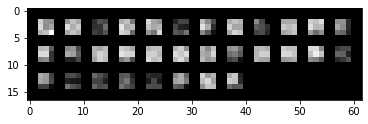

In [38]:
kernel = model.layer1[0].weight.detach().clone()

print(kernel.size())
plot_filter(kernel)

torch.Size([64, 32, 3, 3])


TypeError: Invalid shape (3, 3, 32) for image data

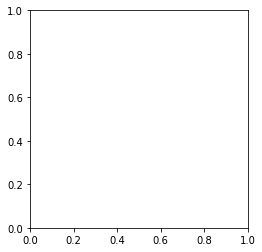

In [39]:
kernel = model.layer2[0].weight.detach().clone()

print(kernel.size())

# plot_filter(kernel[0][2])


for i in range(len(kernel)):
    plot_filter(kernel[i])
    # for j in range(len(kernel[i])):
    #     plot_filter(kernel[i][j])
    #     j += 1

    i += 1